# Using the Gordon Growth Model to Predict Future Electric Car Company Stock Prices

**Alex Khaykin**

**DATA 604**

**Final Project**

In [317]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# Other packages
from pandas import read_csv
from IPython.display import Image 
import datetime
import statistics


# Introduction: Gordon Growth Model can be used to predict future stock prices

The Gordon Growth Model (GGM) is used to calculate the intrinsic value of a company's stock assuming that its shares are worth the sum of all its future dividends after discounting their present value. Although typically used only for mature companies in established markets, here I am using the GGM to attempt to explore how we might expect future stock prices to look for electric car companies Tesla and Rivian once they begin paying shareholder dividends. Note that currently neither company pays shareholder dividends so we can only use anticipated dividends at this stage. 

As a single-stage model, the GGM assumes a company’s dividends continue to grow at a constant rate. The GGM is a simple model that only takes a few inputs to predict the company's stock prices.

### Flow Chart

A flow chart can be designed to show both the theoretical inputs for the Gordon Growth Model (solid line) as well as the actual inputs used (dashed line). 

#### Theoretical Inputs

There are different formulations of the GGM, but all are attempting to estimate the **future stock price** here denoted as *P*. All formulations derive the take some form of:

* Value of next period dividend, here *D<sub>1</sub>*
* Minimum rate of return or the company's cost of equity capital, *r*
* Constant dividend growth rate, *g*


#### Actual Inputs

Note that because neither of the electric car companies, Tesla or Rivian, are currently paying dividends to shareholders, we are using a **consensus anticipated Earnings Per Share (EPS)** to derive the value of *D<sub>1</sub>*. 

For *r*, I will use a value estimated using a Capital Asset Pricing Model, which is what is most commonly used.

For *g*, I will use a trailing twelve-month (TTM) dividend yield that is estimated from the median of the stock sector, here electric vehicles. This means that *g* is the same for both Tesla and Rivian.

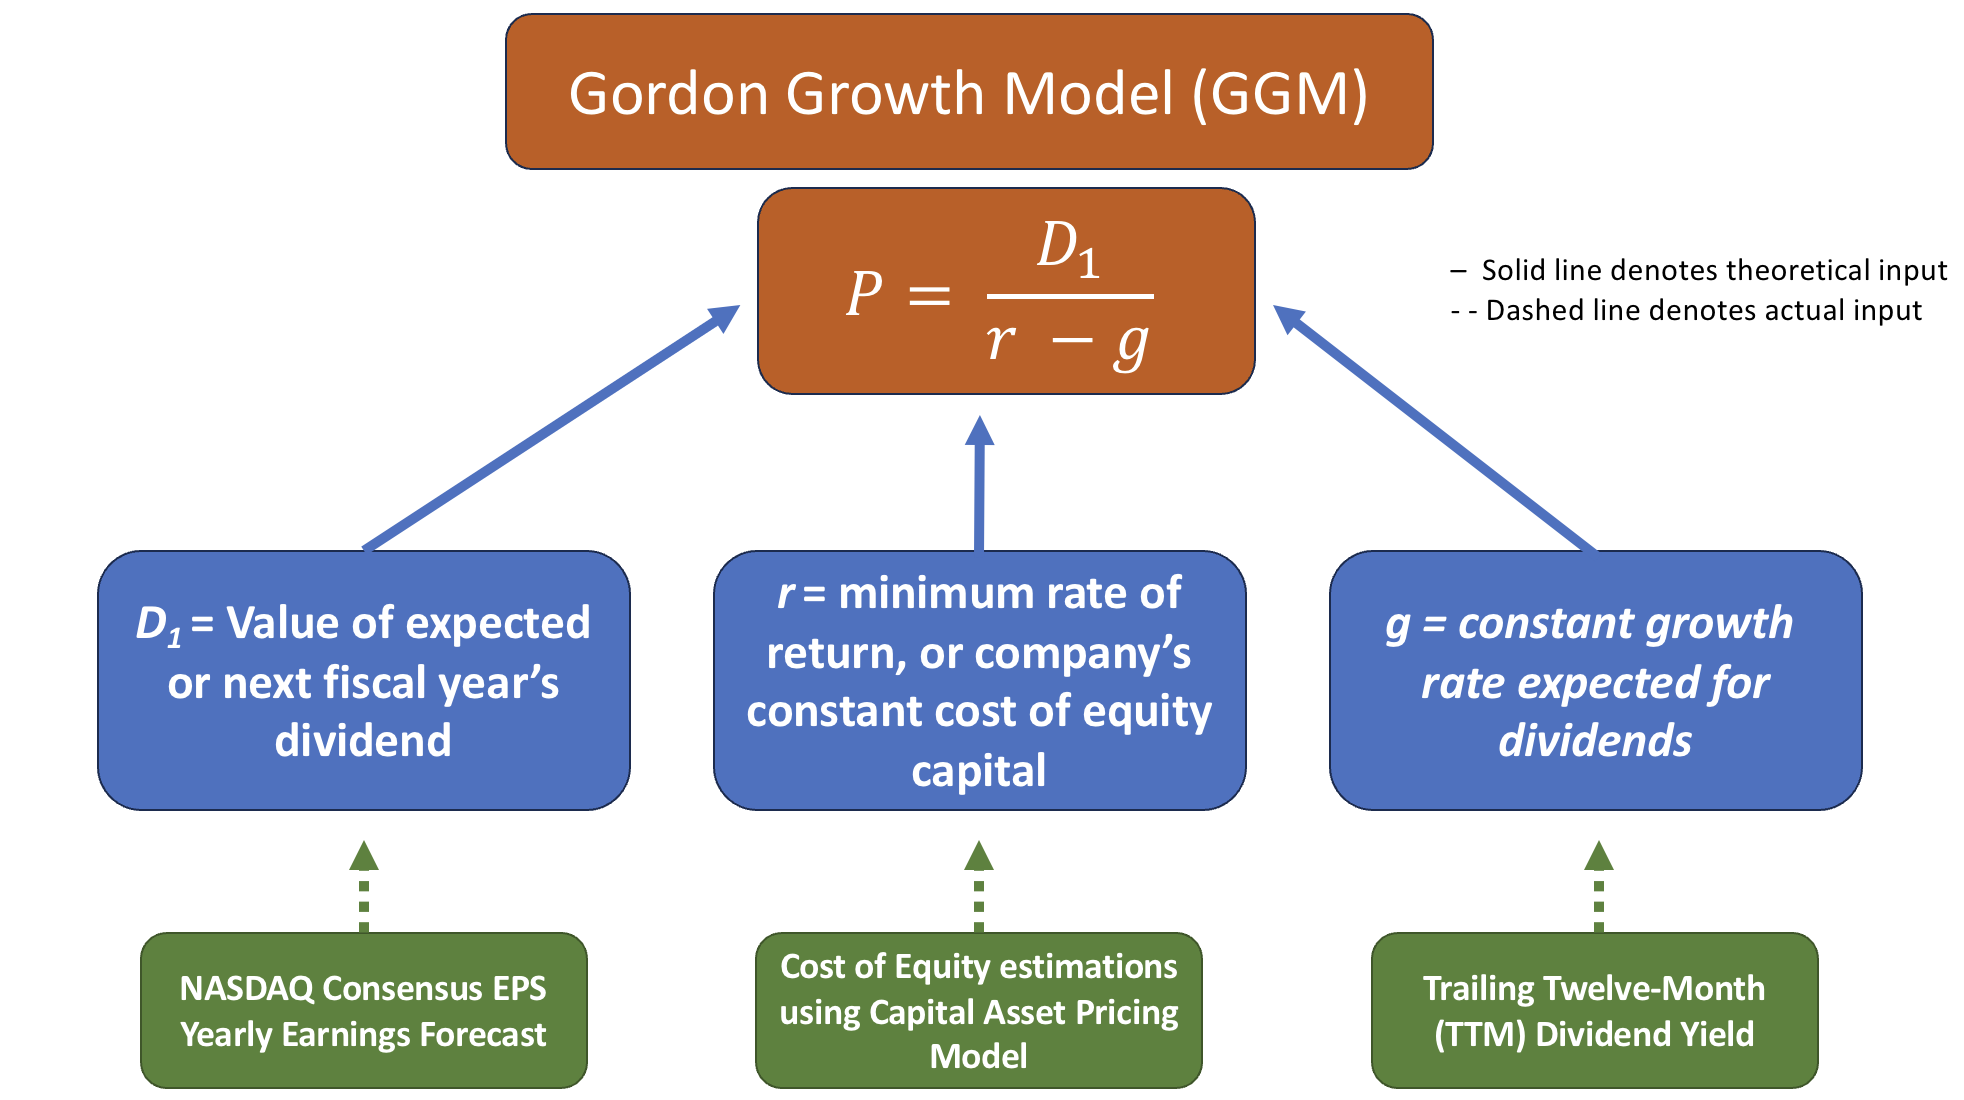

In [473]:
#flow_chart = 'C:\\Users\\akhay\\OneDrive\\Documents\\DATA_604\\Final\\Final Project\\flow_chart.png'
flow_chart = 'alex/flow_chart.png'
Image(filename = flow_chart, width = 900, height = 800)

## GGM Data Inputs

The data inputs for the GGM model were obtained for both Rivian and Tesla stocks. The inputs that will be used are as follows:

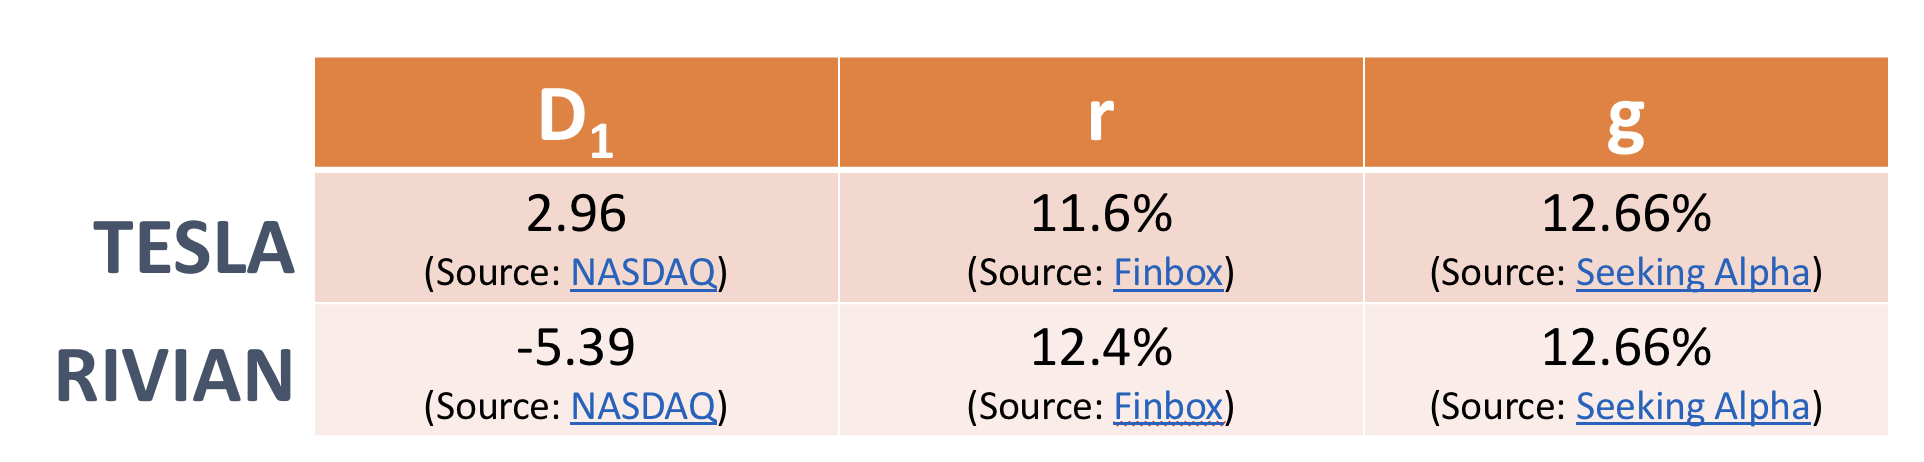

In [319]:
#ggm_inputs = 'C:\\Users\\akhay\\OneDrive\\Documents\\DATA_604\\Final\\Final Project\\inputs.png'
ggm_inputs = 'alex/inputs.png'
Image(filename = ggm_inputs, width = 700, height = 600)



Next, I stored the input values into a state object for each company for later use in simulation:

In [476]:
def tesla_state():
    state = State(D1 = 2.96, r = 0.116, g = 0.1266)
    return state

def rivian_state():
    state = State(D1 = -5.39, r = 0.124, g = 0.1266)
    return state

In [477]:
tesla_state = tesla_state()
tesla_state

,values
D1,2.9600
r,0.1160
g,0.1266


In [478]:
rivian_state = rivian_state()
rivian_state

,values
D1,-5.3900
r,0.1240
g,0.1266


# Analysis Plan

My analysis and modeling plan consists of exploring both historic stock price data to look at current trends and then using these data to estimate future stock prices from a mean annual growth rate. From there, I will then use the GGM to simulate how future stock prices might look given that the mean annual growth rate calculated from the data contains no information about future projections for the stock.

1. Exploring historical stock closing price data to look for trends.
2. Using past performance to simulate future stock prices over the next 20 years using the growth trends thus far.
3. Simulating future stock prices over the next 20 years using the Gordon Growth Model.

# 1. Exploring historical stock closing price data to look for trends. 

Before simulating future stock prices with the GGM, I wanted to explore historical stock prices to see if there are similar trends between Tesla and Rivian. Although Tesla has been a publicly-traded company longer than Rivian, we have data for several years now for both companies.

## 5-Year Historical Stock Price Data

I acquired the 5 year historical stock proce data from [NASDAQ](https://www.nasdaq.com/market-activity/stocks/), which was downloaded as a CSV file. The historical stock prices for Tesla (TSLA) and Rivian (RIVN) included the Date, Closing Price, Volume trading, Opening Price, Daily High, and Daily Low. Before importing the data, I removed $ from the prices and restricted the data to just the Closing Price, as that is all I will use here.

I first imported the CSV files using the read_csv function from Pandas. Notice however, that the dates are in string format, so I need to parse them as dates on import.


In [479]:
# filename = 'C:\\Users\\akhay\\OneDrive\\Documents\\DATA_604\\Final\\Final Project\\Data\\Rivian_5Y_StockHistoricalData.csv'
filename = 'alex/Rivian_5Y_StockHistoricalData.csv'
rivian = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format="%m/%d/%y")
rivian.head()

,Close
Date,
2023-07-11,24.85
2023-07-10,25.51
2023-07-07,24.70
2023-07-06,21.62
2023-07-05,20.43


In [480]:
# filename = 'C:\\Users\\akhay\\OneDrive\\Documents\\DATA_604\\Final\\Final Project\\Data\\Tesla_5Y_StockHistoricalData.csv'
filename = 'alex/Tesla_5Y_StockHistoricalData.csv'
tesla = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format="%m/%d/%y")
tesla.head()

,Close
Date,
2023-07-11,269.79
2023-07-10,269.61
2023-07-07,274.43
2023-07-06,276.54
2023-07-05,282.48


Next, I need to store the most recent closing price so I can use this to estimate the over- or under-valuation of Tesla and Rivian stock later on:

In [481]:
tesla_price = tesla.Close[0]

269.79

In [482]:
rivian_price = rivian.Close[0]

24.85

I need to merge the two data sets on Date to make plotting easier; *x* is the Tesla dataset and *y* is the Rivian dataset.

In [483]:
closing = tesla.merge(rivian, on='Date')

,Close_x,Close_y
Date,,
2023-07-11,269.7900,24.85
2023-07-10,269.6100,25.51
2023-07-07,274.4300,24.70
2023-07-06,276.5400,21.62
2023-07-05,282.4800,20.43
...,...,...
2018-07-18,21.5900,NaN
2018-07-17,21.5127,NaN
2018-07-16,20.6733,NaN


<Axes: xlabel='Date', ylabel='Stock Closing Price, USD'>

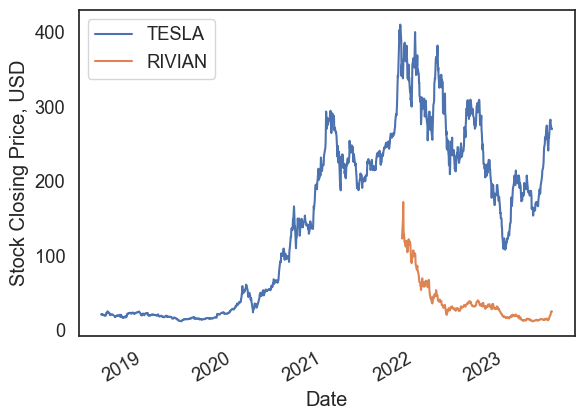

In [484]:
closing.plot(y=["Close_x", "Close_y"],
            xlabel = 'Date',
            ylabel = 'Stock Closing Price, USD',
            label = ["TESLA", "RIVIAN"])

## Conclusion: 

Currently, Tesla stock is trading is nearly 300 USD per share, whereas Rivian stock is just under $25. They are not trading in the same class. Further, over time and despite some fluctuations, Tesla stock is trending upward whereas Rivian stock has plummeted from when it entered the market, although there is a much longer history for Tesla than Rivian.

# 2. Using past performance to simulate future stock prices over the next 20 years using the growth trends thus far.

## Constant Growth Rate Calculated from Past Data for Each Company

Using a simple assumption that annual growth rate can be used to predict future growth, I ran a simulation to see what we might expect the companies' stock prices to do over the next 20 years.

## Building the Simulation Function

The simulation function uses an average growth in the closing stock prices for each of the companies, Tesla and Rivian. It only takes a single parameter, a dataframe.

* Calculates the difference between the ending closing stock price and the beginning closing price
* Finds the number of days that have elapsed in the dataset
* Calculates a daily growth rate
* Converts that daily growth rate to an average annual growth rate

In [485]:
def growth_simulation (df):
    ## Starting date
    t_0 = df.index[-1]
    ## Ending date
    t_end = df.index[0]
    ## Elapsed time, in days
    elapsed_time = t_end - t_0
    elapsed_time = elapsed_time.days
    
    ## Starting close price
    ## If it's Rivian, we have to make some adjustments for the missing data:
    ## Check to see if the first closing price is NaN (if yes, then it's Rivian):
    if pd.isna(df.Close[-1]):
        ## Starting close price for 11/11/21
        p_0 = df.Close[415]
        ## And take off 416 days
        elapsed_time = elapsed_time - 416
    else:
        p_0 = df.Close[-1]
    
    ## Final close price
    p_end = df.Close[0]
    ## Total growth over the entire period
    total_growth = p_end - p_0
    ## Average growth, per day
    daily_growth = total_growth / elapsed_time
    ## Average growth, per year
    annual_growth = daily_growth * 365
    
    print("The average annual growth rate of the stock is:  $", round(annual_growth, 2))
    
    ## Now, start the simulation:
    results = TimeSeries()
    results[t_0.year] = p_0
    ## Loop through 2018 - 2043
    for t in range(t_0.year, 2043):
        results[t+1] = results[t] + annual_growth
    
    print("Assuming constant growth since", t_0.year, " by 2043 we can expect the closing price to be:  $", round(results[2043], 2))
    return results

**TESLA**

In [487]:
tesla_growth = growth_simulation(tesla)
mean_price = round(statistics.mean(tesla_growth.values),2)
print("The average price over time would be $", mean_price)

The average annual growth rate of the stock is:  $ 49.74
Assuming constant growth since 2018  by 2043 we can expect the closing price to be:  $ 1264.49
The average price over time would be $ 642.8


**RIVIAN**

In [488]:
rivian_growth = growth_simulation(rivian)
mean_price = round(statistics.mean(rivian_growth.values),2)
print("The average price over time would be $", mean_price)

The average annual growth rate of the stock is:  $ -25.42
Assuming constant growth since 2018  by 2043 we can expect the closing price to be:  $ -512.59
The average price over time would be $ -194.8


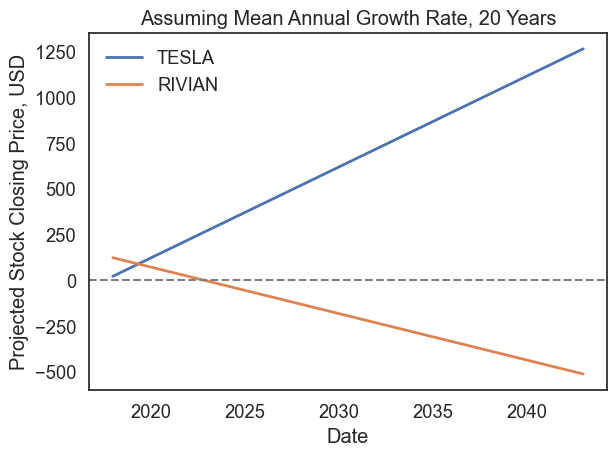

In [489]:
tesla_growth.plot(label = 'TESLA')
rivian_growth.plot(label = 'RIVIAN')
plt.axhline(y = 0, color = 'gray', linestyle = '--')
decorate(xlabel = 'Date',
        ylabel = 'Projected Stock Closing Price, USD',
        title = 'Assuming Mean Annual Growth Rate, 20 Years')

## Conclusion: If we assume constant growth trends for each company, then according to their past performance by 2043 Tesla stock would be valued at nearly 1300 USD per share whereas Rivian would become worthless by the end of 2023.

However, the difficulty with constant growth models is that they are oversimplifying and do not take into account growth in the sector overall. The Gordon Growth Model does.

# 3. Simulating future stock prices over the next 20 years using the Gordon Growth Model.

The first function I define calculates the price based on the Gordon Growth Model, **calc_ggm**. It returns that price for any state parameter it is passed.

In [528]:
def calc_GGM(state):
    P = state.D1 / (state.r - state.g)
    return P

In [529]:
calc_GGM(tesla_state)

-279.24528301886835

Oof, so this means that, based on the current 2023 anticipated annual dividend for shareholders for Tesla, stock should cost -279.24 USD, or effectively zero.

So, next I define a function **calc_stock_diff** which takes a state parameter and the current stock price for the company and returns the percent over- or under-valued a stock currently is for 2023:

In [530]:
def calc_stock_diff(state, current_p):
    print("Current stock price: $", current_p)
    P = round(calc_GGM(state), 2)
    print("GGM calculated stock price: $", P)
    
    diff = round(current_p - P, 2)

    if current_p < P:
        print("The stock is currently undervalued by $", diff)
    else:
        print("The stock is currently overvalued by $", diff)

    ## If the expected stock price is negative, make it zero since stock prices can't be negative:
    if P < 0:
        ## Make a new variable to store the P for the percent change calculation
        P2 = 0
        diff2 = round(current_p - P2, 2)
        perc_change = round((diff2 / current_p),2) * 100
    else:
        perc_change = round((diff / current_p),2) * 100

    print("The percent of change in valuation between GGM and the 2023 value is $", perc_change, "%")

In [531]:
calc_stock_diff(tesla_state, tesla_price)

Current stock price: $ 269.79
GGM calculated stock price: $ -279.25
The stock is currently overvalued by $ 549.04
The percent of change in valuation between GGM and the 2023 value is $ 100.0 %


In [532]:
calc_stock_diff(rivian_state, rivian_price)

Current stock price: $ 24.85
GGM calculated stock price: $ 2073.08
The stock is currently undervalued by $ -2048.23
The percent of change in valuation between GGM and the 2023 value is $ -8242.0 %


So, looking at these 2023 numbers, it looks like the opposite prediction for Tesla (decline) vs. Rivian (growth) versus when we looked at the constant growth model. Hmm.

Next, let's create a simulation over 20 years to see what we might see.

First, I will make an **update_func** to update the company's state dataframe at each time step. Then, I will create a **ggm_simulation** function to calculate the projected price at each step.

At each time step:
* Runs the update function, which replaces the *D<sub>1</sub>* with *D<sub>1</sub>* times (1 + *g*)
* Calculates the new stock price using the GGM function, **calc_ggm**
* Stores the estimated stock price in a Time Series

In [533]:
def update_func(state):
    D1, g, r = state.D1, state.g, state.r

    ## At each time step, the D1 (shareholder EPS) is the D1 * (1 + g)
    D1 = D1 * (1 + g)   
    
    return State(D1 = D1, g = g, r = r)



def ggm_simulation(state, current_p):
    
    ## Simulated closing stock price
    closing_prices = TimeSeries()
    
    ## Set t_0 & t_end
    t_0 = 2023
    t_end = 2043
    
    ## Set the first closing price to the 2023 price:
    closing_prices[t_0] = current_p
    
    ## Loop through the years in the years array:
    #for y in (years):
    for t in range(t_0, t_end):
        state = update_func(state)
        closing_prices[t+1] = round(calc_GGM(state), 2)
        
    return closing_prices

In [534]:
tesla_ggm = ggm_simulation(tesla_state, tesla_price)
mean_price = round(statistics.mean(tesla_ggm.values),2)
print("The average price over time would be $", mean_price)

The average price over time would be $ -1152.62


In [535]:
rivian_ggm = ggm_simulation(rivian_state, rivian_price)
mean_price = round(statistics.mean(rivian_ggm.values),2)
print("The average price over time would be $", mean_price)

The average price over time would be $ 8653.45


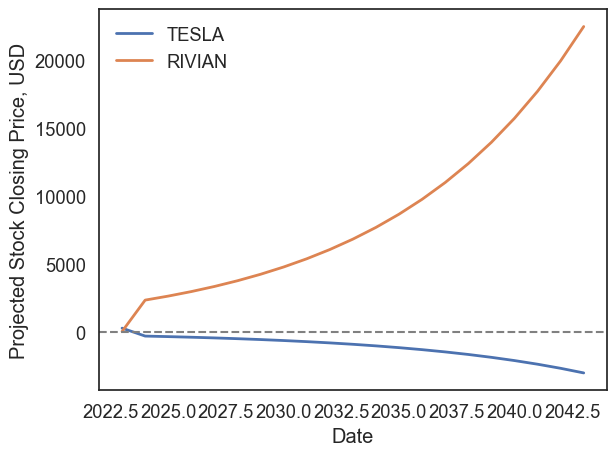

In [536]:
tesla_ggm.plot(label = 'TESLA')
rivian_ggm.plot(label = 'RIVIAN')
plt.axhline(y = 0, color = 'gray', linestyle = '--')
decorate(xlabel = 'Date',
        ylabel = 'Projected Stock Closing Price, USD')

# Conclusion: The Gordon Growth Model predicts an opposite trend than using the historical data - Tesla will crash within a year, and Rivian prices will climb nearly exponentially.

The key difference between the constant growth model in Part 2 and the GGM is that the constant growth model only uses historical data to predict future prices. The GGM takes more information into account, including both how the stock itself is predicted to grow as well as how the market sector is expected to grow, and ignores past performance.

Both models are very simplifying, and the assumptions used determine the outputs. A major limitation of the GGM used here is that it assumes that over the 20-year period, both the stock growth rate and the market sector growth rate will remain constant. This is unlikely to occur. Further, because the GGM does not take historical performance into account, it is not accounting for the fact that Tesla stock has continued to rise over the past 5 years despite some dips in prices. It also does not account for the fact that Rivian stock is currently at an all-time low.

Future directions would attempt to model stock prices using a hybrid model that includes both past trends as well as different growth projections for both companies and the electric vehicle sector.